In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from commonen import h5dataset, traininer, onnxexporter

class JassTimeRegression(nn.Module):
    def __init__(self, num_inputs=72):
        super(JassTimeRegression, self).__init__()
        in_dim = num_inputs * 37
        self.network = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, state_idx):
        one_hot = F.one_hot(state_idx, num_classes=37).float()
        one_hot = one_hot.view(one_hot.size(0), -1) # Flatten the input
        return self.network(one_hot)

In [2]:
DATASET_PATH = '../log_parser/dataset/flat_time.hdf5'
MODLE_PATH = './models/jass_time_reg.pth'
BATCH_SIZE = 256
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# Initialize model, optimizer, and loss function
model = JassTimeRegression().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (1-((y_true - y_pred)/((y_pred + y_pred)/2))).float().mean()
loss_fn = lambda output, action: F.mse_loss(output, action.unsqueeze(1))

# set up trainer
traininer = traininer.Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [3]:
# Train the model
traininer.train(NUM_EPOCHS)

Validation Epoch 1: 100%|██████████| 18159/18159 [01:08<00:00, 263.63it/s]


Epoch 1/10 - Train Loss: 5.0769, Train Accuracy: 0.7996, Val Loss: 5.2458, Val Accuracy: 0.7936
Model saved at epoch 1 with validation loss 5.2458


Validation Epoch 2: 100%|██████████| 18159/18159 [01:07<00:00, 268.32it/s]


Epoch 2/10 - Train Loss: 5.0339, Train Accuracy: 0.8009, Val Loss: 5.2195, Val Accuracy: 0.7934
Model saved at epoch 2 with validation loss 5.2195


Validation Epoch 3: 100%|██████████| 18159/18159 [01:07<00:00, 267.37it/s]


Epoch 3/10 - Train Loss: 5.0235, Train Accuracy: 0.8004, Val Loss: 5.2291, Val Accuracy: 0.7773


Validation Epoch 4: 100%|██████████| 18159/18159 [01:08<00:00, 265.05it/s]


Epoch 4/10 - Train Loss: 5.0171, Train Accuracy: 0.8002, Val Loss: 5.2314, Val Accuracy: 0.8301


Validation Epoch 5: 100%|██████████| 18159/18159 [01:07<00:00, 267.86it/s]


Epoch 5/10 - Train Loss: 5.0130, Train Accuracy: 0.8000, Val Loss: 5.2892, Val Accuracy: 0.8599


Validation Epoch 6: 100%|██████████| 18159/18159 [01:07<00:00, 267.40it/s]


Epoch 6/10 - Train Loss: 5.0100, Train Accuracy: 0.7999, Val Loss: 5.2284, Val Accuracy: 0.8121


Validation Epoch 7: 100%|██████████| 18159/18159 [01:08<00:00, 266.30it/s]


Epoch 7/10 - Train Loss: 5.0077, Train Accuracy: 0.7997, Val Loss: 5.2141, Val Accuracy: 0.8103
Model saved at epoch 7 with validation loss 5.2141


Validation Epoch 8: 100%|██████████| 18159/18159 [01:01<00:00, 295.76it/s]


Epoch 8/10 - Train Loss: 5.0056, Train Accuracy: 0.7996, Val Loss: 5.2024, Val Accuracy: 0.7870
Model saved at epoch 8 with validation loss 5.2024


Validation Epoch 9: 100%|██████████| 18159/18159 [01:00<00:00, 298.53it/s]


Epoch 9/10 - Train Loss: 5.0041, Train Accuracy: 0.7993, Val Loss: 5.2107, Val Accuracy: 0.7990


Validation Epoch 10: 100%|██████████| 18159/18159 [01:00<00:00, 297.90it/s]

Epoch 10/10 - Train Loss: 5.0023, Train Accuracy: 0.7992, Val Loss: 5.2705, Val Accuracy: 0.8141


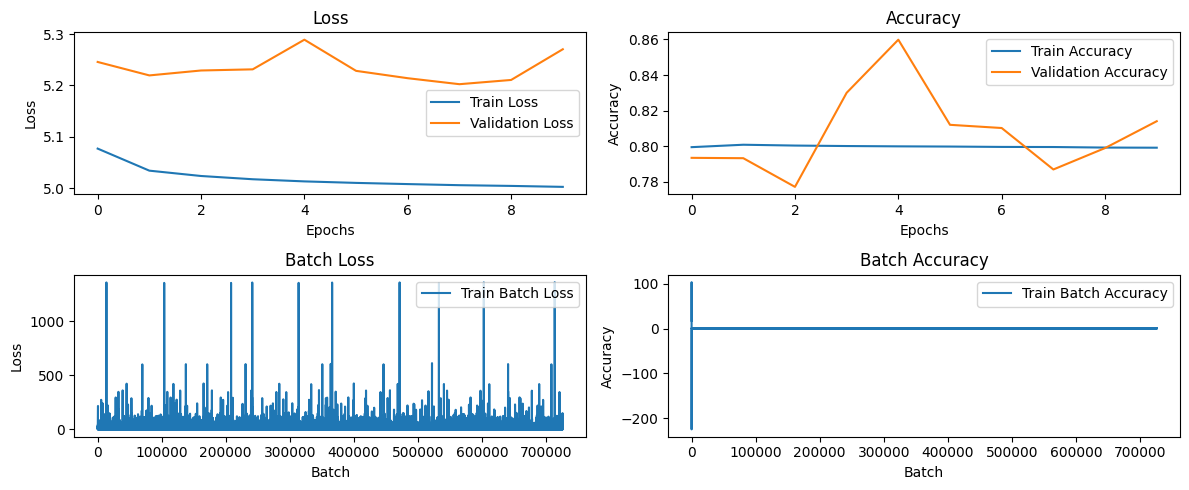

In [4]:
# Create graph
traininer.monitor.plot()

In [5]:
# export the model to ONNX
ONNX_PATH = './onnx/jass_time_dnn.onnx'
model = JassTimeRegression() # Reinitialize the model on CPU
onnxexporter.onnx_exporter(
    model=model,
    in_dim=72,
    model_path=MODLE_PATH,
    output_path=ONNX_PATH
)

Successfully loaded trained model state dictionary from ./models/jass_time_reg.pth
Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./onnx/jass_time_dnn.onnx
